In [1]:

#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

2023-12-02 00:51:38.982980: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 00:51:39.188464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 00:51:39.188509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 00:51:39.227695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 00:51:39.309605: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 00:51:39.310447: I tensorflow/core/platform/cpu_feature_guard.cc:1

Done


In [2]:
!apt-get update
!apt-get install -y libsndfile1

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# Importing Data

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [47]:
#preparing data set

ravdess = "Datasets/RAVDESS/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_04', 'Actor_23', 'Actor_10', 'Actor_13', 'Actor_09', 'Actor_16', 'Actor_22', 'Actor_07', 'Actor_03', 'Actor_12', 'Actor_06', 'Actor_15', 'Actor_20', 'Actor_19', 'Actor_18', 'Actor_02', 'Actor_17', 'Actor_01', 'Actor_08', 'Actor_21', 'Actor_11', 'Actor_05', 'Actor_14', 'Actor_24']


In [48]:
#Crema = "Datasets/CREMA_D/AudioWAV/"
Tess = "Datasets/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
#Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [49]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [50]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-07-01-02-02-24.wav
03
Datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-07-01-02-01-04.wav
3
03-01-03-02-02-01-24.wav


In [51]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0  disgust  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1      sad  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
2      sad  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
3      sad  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
4    happy  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
______________________________________________
      Emotions                                               Path
1435       sad  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1436   neutral  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1437  surprise  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1438      fear  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1439     happy  Datasets/RAVDESS/audio_speech_actors_01-24/Act...
_______________________________________________
Emotions
neutral     288
disgust     192
sad         192
happy       192
surprise    192
fear        192
angry       192
Name: count, dty

**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [8]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
fear       1271
sad        1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [52]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
disgust     400
surprise    400
angry       400
happy       400
fear        400
sad         400
neutral     400
Name: count, dtype: int64


**Integration**

In [56]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df,Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,disgust,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1,sad,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
2,sad,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
3,sad,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
4,happy,Datasets/RAVDESS/audio_speech_actors_01-24/Act...


In [57]:
print(data_path.Emotions.value_counts())


Emotions
neutral     688
disgust     592
sad         592
happy       592
surprise    592
fear        592
angry       592
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

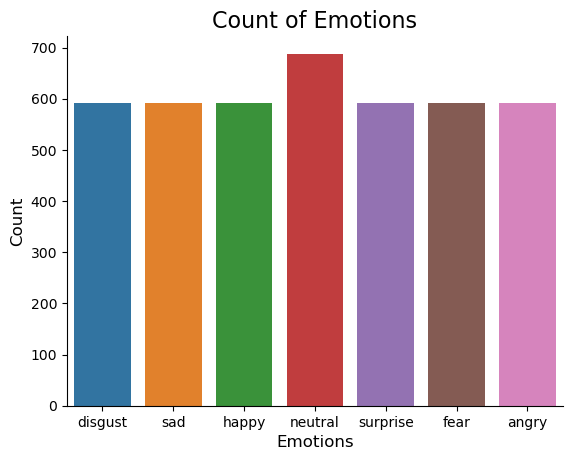

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_path is your DataFrame
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')  # Specify x='Emotions' to indicate the column containing emotion labels
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [59]:
data,sr = librosa.load(file_path[0])
sr

22050

In [60]:
ipd.Audio(data,rate=sr)

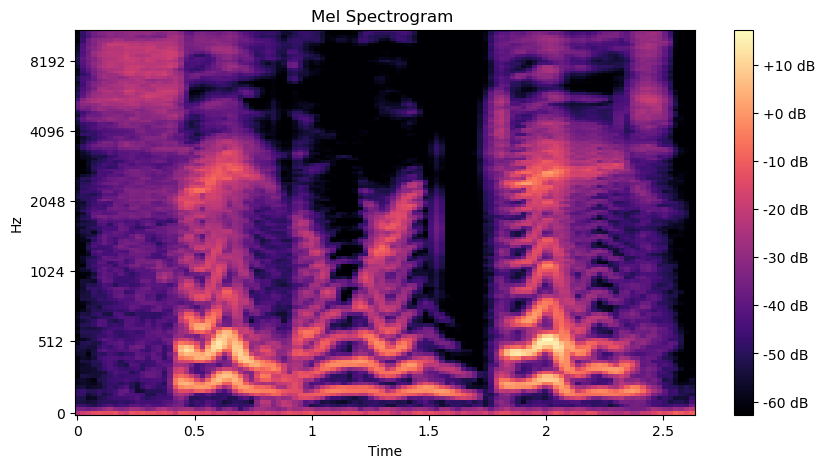

In [61]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

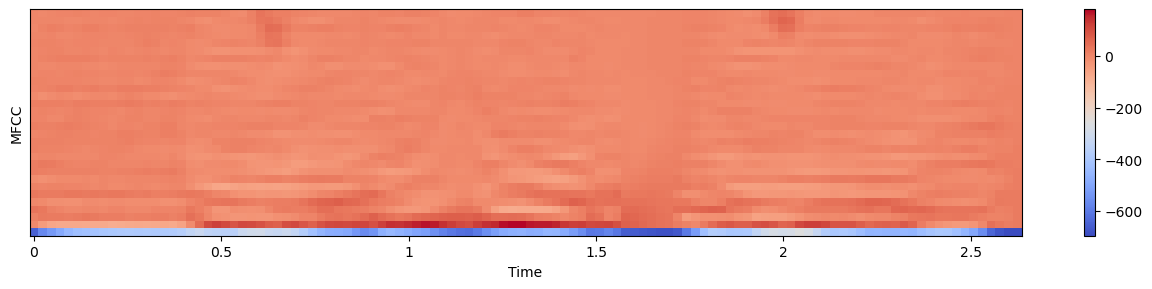

In [62]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [63]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
# def stretch(data, rate=0.8):
#     return librosa.effects.time_stretch(data, rate)
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
# def pitch(data, sampling_rate, pitch_factor=0.7):
#     return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor=pitch_factor)
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

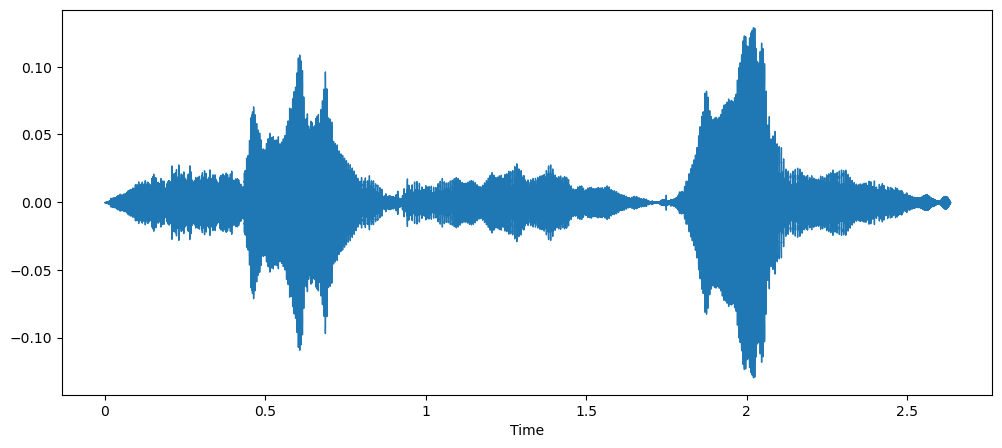

In [64]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

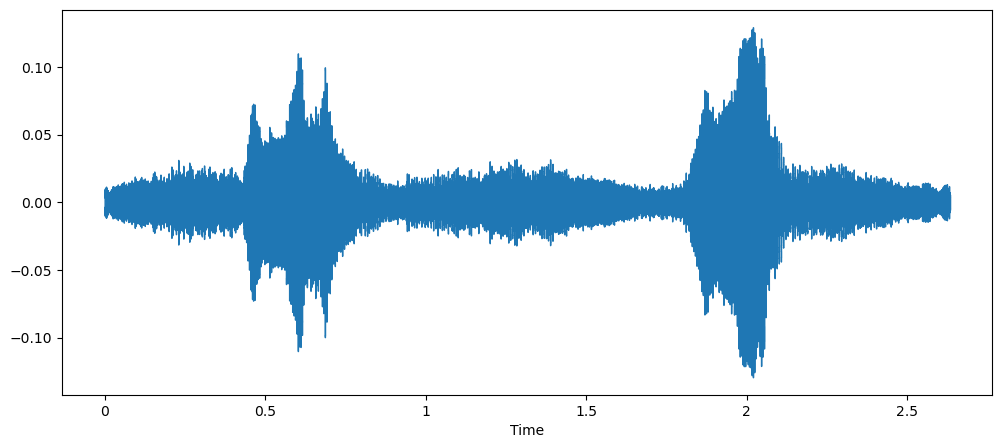

In [65]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

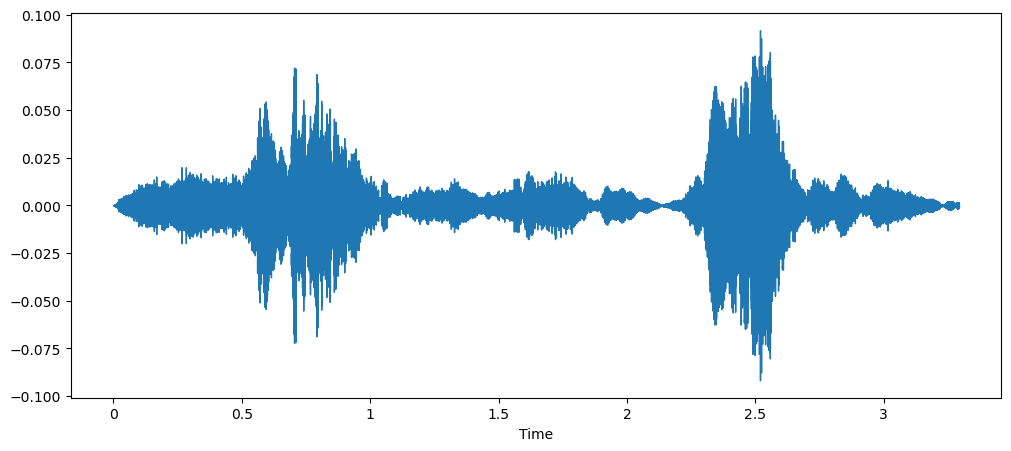

In [66]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

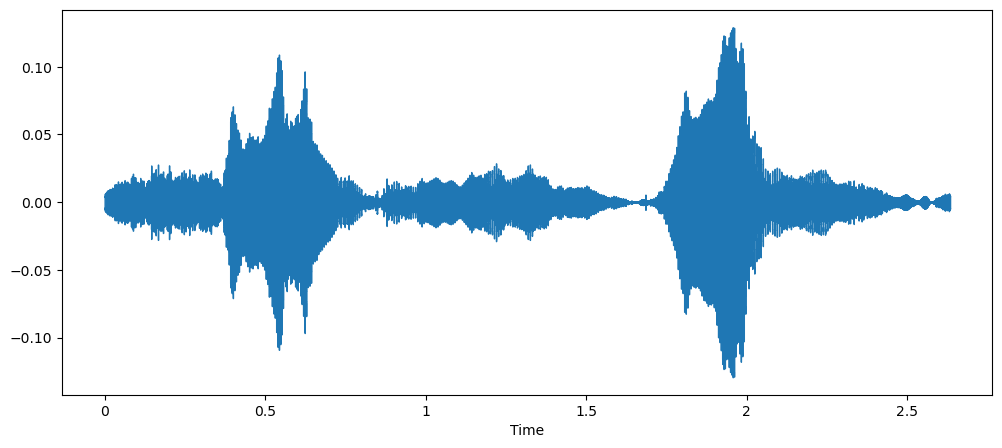

In [67]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

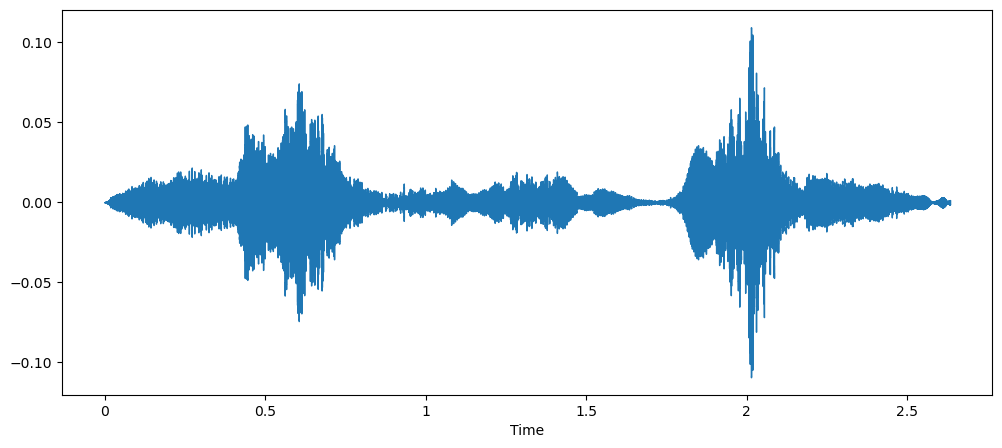

In [68]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

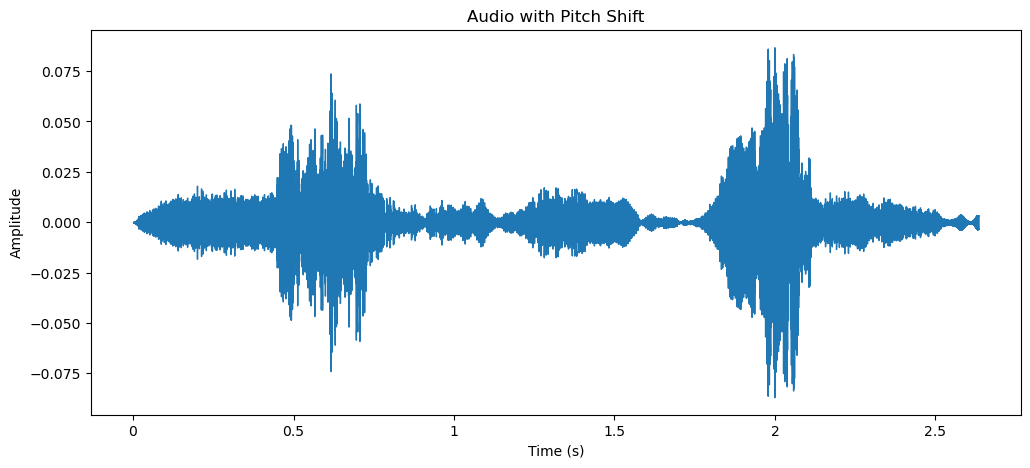

In [69]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# PITCH
def pitch(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(data, n_steps=pitch_factor, sr=sampling_rate)

# Example usage
x = pitch(data, sr)

# Plotting and audio playback
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
plt.title('Audio with Pitch Shift')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.Audio(x, rate=sr)


# Feature extraction

In [70]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
# def rmse(data,frame_length=2048,hop_length=512):
#     rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
#     return np.squeeze(rmse)
def rmse(data, frame_length=2048, hop_length=512):
    rmse_value = librosa.feature.rms(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse_value)






def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [71]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


# Noraml way to get features

In [72]:
import numpy as np
import librosa
from tqdm import tqdm
import pandas as pd

# Define your noise, stretch, pitch functions here

def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse_value = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)[0]
    return np.squeeze(rmse_value)




def mfcc(data, sr, n_mfcc=13, hop_length=512, n_fft=2048):
    mfcc_feat = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return np.ravel(mfcc_feat)


def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)

    # Assume you have defined your noise, stretch, pitch functions
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))

    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))

    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1)
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))

    return audio

# Load your data
# Replace this line with your actual data loading code
# Example assuming your CSV file is named 'your_data.csv'
data_path = pd.read_csv('data_path.csv')

X, Y = [], []

for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions)):
    features = get_features(path)
    for i in features:
        X.append(i)
        Y.append(emotion)

# Continue with your model training or other tasks using X and Y


4240it [06:11, 11.41it/s]


# Faster way to get features
***Parallel way***

**Dont be afraid from red lines that Normal**


This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [42]:
# '''from joblib import Parallel, delayed
# import timeit
# start = timeit.default_timer()
# # Define a function to get features for a single audio file
# def process_feature(path, emotion):
#     features = get_features(path)
#     X = []
#     Y = []
#     for ele in features:
#         X.append(ele)
#         # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#         Y.append(emotion)
#     return X, Y

# paths = data_path.Path
# emotions = data_path.Emotions

# # Run the loop in parallel
# results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# # Collect the results
# X = []
# Y = []
# for result in results:
#     x, y = result
#     X.extend(x)
#     Y.extend(y)


# stop = timeit.default_timer()

# print('Time: ', stop - start)  '''

In [73]:
len(X), len(Y), data_path.Path.shape


(16960, 16960, (4240,))

# Saving features

In [74]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,14031,14032,14033,14034,14035,14036,14037,14038,14039,Emotions
0,0.000000,0.000000,0.000000,0.060059,0.282715,0.288086,0.368164,0.307617,0.205078,0.220703,...,0.061311,0.078970,0.031544,-0.008092,-0.004664,-0.059661,-0.108838,-0.014415,0.004285,disgust
1,0.266602,0.390137,0.510742,0.496582,0.486328,0.489746,0.498047,0.491211,0.493652,0.490234,...,0.572860,0.958423,0.282640,0.978564,-0.347183,-2.103475,-2.385568,0.172057,-0.363943,disgust
2,0.017578,0.123047,0.218750,0.332520,0.464355,0.478027,0.456543,0.398438,0.278809,0.165039,...,0.560006,0.094583,-0.136444,-0.158609,0.130956,0.185630,0.016794,0.033975,0.119394,disgust
3,0.248047,0.375000,0.491699,0.483887,0.489258,0.487305,0.494141,0.507812,0.507324,0.496094,...,0.022588,-0.245530,0.905119,-0.518874,-2.593897,-1.556854,1.376401,0.213972,-0.522395,disgust
4,0.367676,0.520508,0.609375,0.498535,0.382812,0.307129,0.303711,0.311523,0.349609,0.363770,...,0.046914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad


In [2]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,14031,14032,14033,14034,14035,14036,14037,14038,14039,Emotions
0,0.000000,0.000000,0.000000,0.060059,0.282715,0.288086,0.368164,0.307617,0.205078,0.220703,...,0.061311,0.078970,0.031544,-0.008092,-0.004664,-0.059661,-0.108838,-0.014415,0.004285,disgust
1,0.266602,0.390137,0.510742,0.496582,0.486328,0.489746,0.498047,0.491211,0.493652,0.490234,...,0.572860,0.958423,0.282640,0.978564,-0.347183,-2.103475,-2.385568,0.172057,-0.363943,disgust
2,0.017578,0.123047,0.218750,0.332520,0.464355,0.478027,0.456543,0.398438,0.278809,0.165039,...,0.560006,0.094583,-0.136444,-0.158609,0.130956,0.185630,0.016794,0.033975,0.119394,disgust
3,0.248047,0.375000,0.491699,0.483887,0.489258,0.487305,0.494141,0.507812,0.507324,0.496094,...,0.022588,-0.245530,0.905119,-0.518874,-2.593897,-1.556854,1.376401,0.213972,-0.522395,disgust
4,0.367676,0.520508,0.609375,0.498535,0.382812,0.307129,0.303711,0.311523,0.349609,0.363770,...,0.046914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad


In [3]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
14036        True
14037        True
14038        True
14039        True
Emotions    False
Length: 14041, dtype: bool


In [4]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
14036       False
14037       False
14038       False
14039       False
Emotions    False
Length: 14041, dtype: bool


(16960, 14041)

In [5]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
14036       0
14037       0
14038       0
14039       0
Emotions    0
Length: 14041, dtype: int64

# Data preparation

In [6]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [7]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [8]:
print(Y.shape)
X.shape

(16960, 7)


(16960, 14040)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13568, 14040), (13568, 7), (3392, 14040), (3392, 7))

In [10]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [11]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13568, 14040), (13568, 7), (3392, 14040), (3392, 7))

In [12]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [14]:

early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

In [ ]:
"""model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()"""

In [ ]:
"""hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)"""

In [ ]:
"""print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

# CNN model

In [15]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((13568, 14040, 1), (13568, 7), (3392, 14040, 1), (3392, 7))

In [16]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14040, 512)        3072      
                                                                 
 batch_normalization (Batch  (None, 14040, 512)        2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 7020, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 7020, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 7020, 512)         2048      
 chNormalization)                                                
                                                        

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50


2023-12-02 00:56:06.686161: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 761978880 exceeds 10% of free system memory.
2023-12-02 00:56:08.790002: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1840250880 exceeds 10% of free system memory.
2023-12-02 00:56:09.243329: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1840250880 exceeds 10% of free system memory.
2023-12-02 00:56:09.885408: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1840250880 exceeds 10% of free system memory.
2023-12-02 00:56:10.357365: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1840250880 exceeds 10% of free system memory.


In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

In [ ]:
df0

Some plots of multi_model
______________________________________________


# CLSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

Another  model (CLSTM)  omnia model
_____________________________________________________

In [ ]:
#Build the model

# define model
"""model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))


model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True))
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True))
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()"""

In [ ]:
"""from keras.utils.vis_utils import plot_model
plot_model( model000, show_shapes=True, show_layer_names=True, to_file='model000.png')"""

In [ ]:
"""model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""

In [ ]:
"""hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=40, validation_data=(x_testcnn, y_test))"""

In [ ]:
"""print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

In [ ]:
# predicting on test data.
"""pred_test00 = model000.predict(x_testcnn)
y_pred00 = encoder.inverse_transform(pred_test)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)"""

# Evalutation

Results of best model

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk")

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

# Test script
* That can predict new record

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

In [ ]:
import pickle

with open('/kaggle/working/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/kaggle/working/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

In [ ]:
import librosa

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [ ]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")